# ANN Classifier example in R

#### This is a simple tutorial for applying our ANN Classifier model on AML samples. 
- Our color list follows a simple methodology of lightening cell-type color as we proceed from immature cells to mature cells 
- Our Model is located in the Model folder and it needs to be loaded before running the classification
- You can run the model by classification function.

** Enjoy it as much as we do! :)

In [11]:
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(reticulate))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(Matrix))


In [2]:

#Download files if they are not there.

if (!file.exists('Model')){ 
    dir.create(file.path('Model')) 
}
if (!file.exists('Model/ANNClassifier_features.txt')){ 
    download.file("https://nextcloud.computecanada.ca/index.php/s/BCXjka8wcrCyNas/download",
     "Model/ANNClassifier_features.txt")
}
if(!file.exists('Model/ANNClassifier.sav')){ 
    download.file("https://nextcloud.computecanada.ca/index.php/s/c2X5MyEsWmRmLCP/download",
     'Model/ANNClassifier.sav')
}



if (!file.exists('test_data')){
    dir.create(file.path('test_data')) 
    }
if(!file.exists('test_data/GallenFull_integrated.RDat')){ 
    download.file("https://nextcloud.computecanada.ca/index.php/s/TeYDZPEcdRENH6d/download",
                               "test_data/GallenFull_integrated.RDat")
}



Color palette we love:

In [12]:
color_palette <- c( 
#purple
'CD34+ HSC' = '#5A3AAB',
'CD34+ HSC-cycle' = '#7F38CF',
'CD34+ MultiLin' = '#BF7EED',

#Myeloid lineage  #blue
'Promyelocyte'= '#365D93',
'Myelocyte'= '#4D7BA8',
'Metamyelocyte/Band neutrophil'= '#6489BD',
'S100A+ preNeutrophil'= '#7AA7D2',
'S100A+ preNeutrophil (cycling)'= '#91C5E7',
    


'CD14+MHCIIlow monocyte'= '#2357F9',
'CD14+MHCIIhigh monocyte'= '#5E80FF',
'CD16+ monocyte'= '#1242e4',
'Macrophage'= '#0F35B0',
    
# Dendritic cell  = green     

'CDP'= '#009999',

'cDC1'= '#00E6E6',
'cDC2 (cycling)'= '#00B2B2',
'cDC2'= '#00CCCC',
'MoDC'= '#28b5f7',


'pre-pDC (myeloid origin)'= '#006633',
'pre-pDC (lymphoid origin)'= '#008066',
'pDC'= '#00FFFF',
 
 'Mast cell' = '#575f88' , 
    
# Ery #red
'CD34+ MEP' = '#78222E',
'Megakaryocyte progenitor'= '#8C2B3D',
'Megakaryocyte'= '#A03D51',
'Platelet' = '#ed9393',

'Early SOX4+ erythroblast'= '#B75268',
'Intermediate EPCAM+ erythroblast'= '#C9617A',
'Late hemoglobin+ erythroblast'= '#DA748C',
# 'Fetal HBG+ erythrocyte'= '#E78E9C',
'Erythrocyte'= '#DC143C',    

# Lymphocyte B
'CD34+ LMPP' = "#C83DE0",
'CD34+ CLP' = "#CF5BE3",
# 'CLP'= '#C71585',
# 'ILC' = '#D37EED',        
'preB cell (cycling)'= '#D582F0', 
'preB cell'='#D986E7', 
'proB cell (cycling)'='#E091E1', 
'proB cell'='#E69DDC', 
'Naive B cell'= '#EEA9D6',
'Memory B cell'='#F3B6D1', 
'Plasma Cell' = '#C71585',

'ILC' = '#faa997',   #
# Lymphocyte T/NK
'T/NK cell (cycling)'= '#FF5733',
'Naive CD8 T cell'= '#FF7F50',
'Naive CD4 T cell'= '#FFA07A',
'Effector/Memory CD4 T cell'= '#FFC2A7',
'Treg'= '#FFD1A7',
'GZMK+ CD8 T cell'= '#FEDCB3',
'GZMB+ CD8 T cell'= '#FEE0C2',
'MAIT'= '#FEE5D0',
'Gamma-delta T cell'= '#FEEBDB',
'IFN-activated T cell'= '#FEEDE6',
'CD16+ NK'= '#FEC9A8',
'Tissue-resident NK cell'= '#FED6BB',
'CD56+ NK'= '#FEE2CE',


'Stromal' = "#ffd000" 

)


## Classification 
- Features are taken from HCA reference data (which was run with Cell Ranger (version 5) and  GRCh38 standard reference (Ensembl 98) )

In [13]:
# load features
modeldir='Model/'
features <- read.csv(paste0(modeldir,"ANNClassifier_features.txt"),header=F)
features = as.vector(features)$V1
# load the model from disk
model = reticulate::py_load_object(paste0(modeldir,'ANNClassifier.sav'))

In [14]:
classification <- function(seurat_obj,features_all,model_all_cell_types){
        
    #seurat_obj was filtered for unexpressed genes. We add genes that are
    #in the model but not in seurat_obj and give them zero expression values.
    
    # Warning if the same gene name are not used between the classifier and query dataset
    # this might result in some data getting discarded.
    absent_features <- setdiff(features_all,rownames(seurat_obj))
    temp <- as(matrix(0, ncol = length(absent_features), nrow = length(colnames(seurat_obj))),"sparseMatrix")
    rownames(temp)=colnames(seurat_obj)
    colnames(temp) <- absent_features

    if(grepl('^5.', Version(seurat_obj))){ #V5
        final_df <- cbind(Matrix::t(seurat_obj[["RNA"]]$data),temp)
    }else{#V3
        final_df <- cbind(Matrix::t(seurat_obj@assays$RNA@data),temp) 
    }
    
    # annotate cell types
    df_test_all_ct <- final_df[, features_all]
    pred_cell_types = model_all_cell_types$predict(df_test_all_ct)

    # Add the new annotations to the Seurat Object
    seurat_obj@meta.data$'ANNpredictions' = pred_cell_types
    return (seurat_obj)
}


## Read in your sample here

In [15]:
load(file = 'test_data/GallenFull_integrated.RDat', verbose=T)
GalenFull

Loading objects:
  GalenFull


An object of class Seurat 
27899 features across 15685 samples within 1 assay 
Active assay: RNA (27899 features, 0 variable features)
 2 layers present: counts, data
 3 dimensional reductions calculated: umap, pca, X_harmony

<b> Normalization step:</b>
- We normalize over 10000 as it approximate median UMI in AML samples using our current chemistry

In [16]:
## Normalization in Seurat
## Here, the test dataset was already normalized, but this operation is idempotent in Seurat so do it again to
## demonstrate what is needed when we start from raw count data
GalenFull <- NormalizeData(GalenFull, margin = 1,normalization.method = "LogNormalize", scale.factor = 10000)

###  Running the Classification function 

In [17]:
GalenFull <- classification(GalenFull,features,model)

<b>- UMAP of result

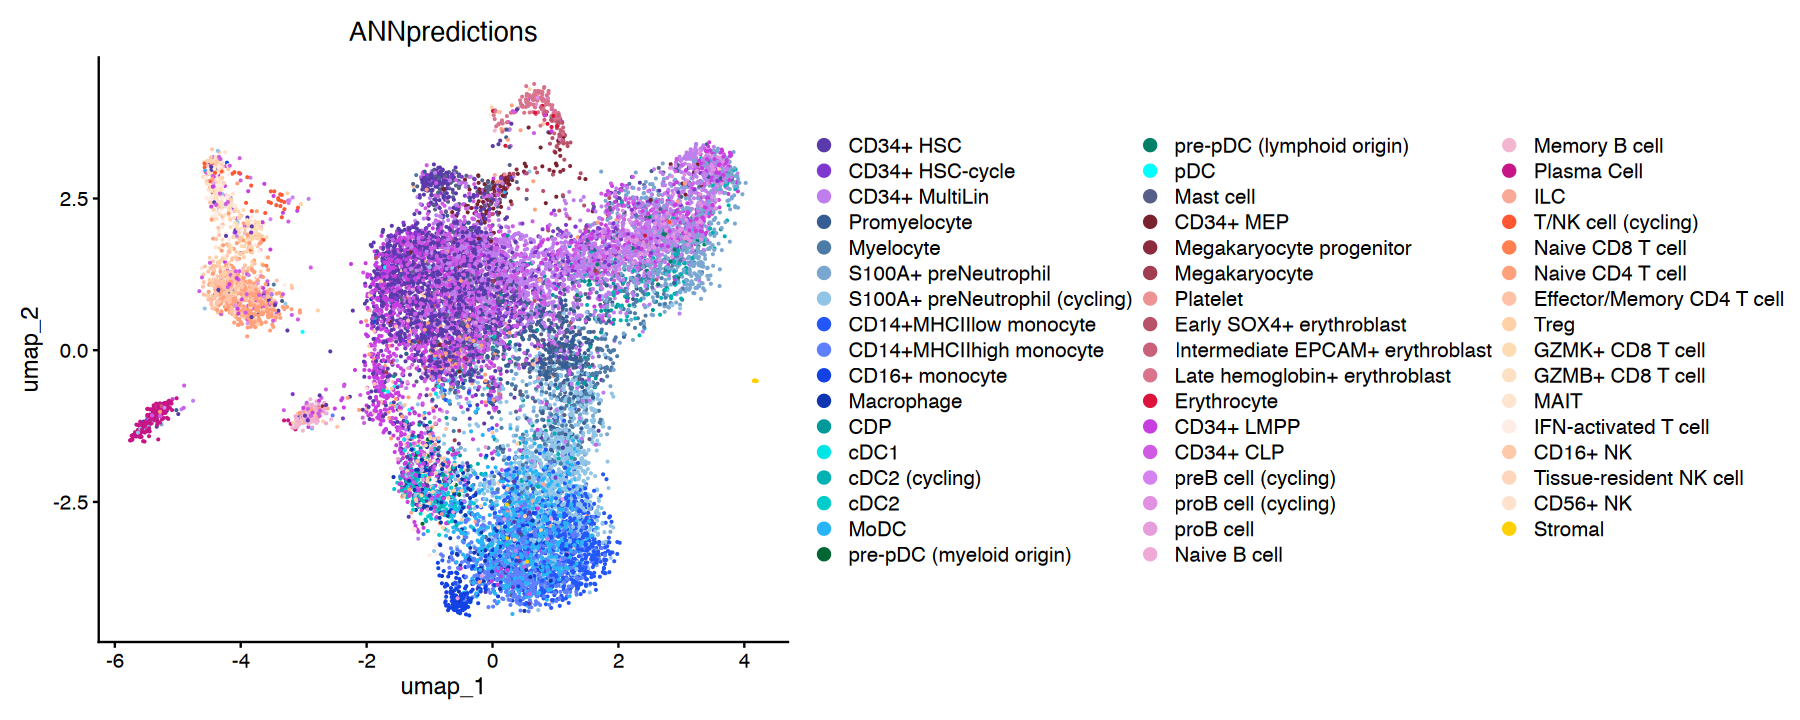

In [18]:
GalenFull@meta.data$'ANNpredictions' <- factor(GalenFull@meta.data$'ANNpredictions', levels=names(color_palette))
options(repr.plot.height =6, repr.plot.width=15)
DimPlot(GalenFull, reduction = 'umap', group.by = 'ANNpredictions', cols = color_palette, pt.size = 0.1,  
label =F, na.value = 'lightgrey', repel = TRUE, raster=FALSE)

<b> You are done!